### Apendix A. Data Preparation

As a part of the data preparation, labelled training images are standardized in terms of its orientation and dimensions. The number of dataset is increased by augmentation. The data is then saved into a csv file for later retrieval. 


**Table of Contents**

1. Standardize image characteristics (i.e., orientation and size)
2. Augment datasets
3. Save data into a csv file
4. Retrieve and regenerate images from the saved csv file

***

#### 1. Standardize image characteristics (i.e., orientation and size)    

Given a set of labelled training images, the first step is to standardize the image orientation and size. It is assumed that the image initially has the following dimensions: 4128x2322 pixels.

#### 1.1. Create a function that resize the images and makes sure that the orientations are the same  

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


def create_gray_image(img_filename):
    """
    Accepts a colored image as an input and returns a 2D array of a shrunk image (to 2% of its original size) 
    input 
        filename: specify image filename and path
    output
        returns a 2d numpy array of the gray image
    """
        
    #a. read image file
    img=cv2.imread(img_filename)

    #b. resize image to 2% its original dimensions
    img = cv2.resize(img, (0,0), fx=0.02, fy=0.02)

    #c. change image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #check
    #plt.imshow(gray) 
    #plt.show()

    x,y=gray.shape #get gray image dimensions
    #print(x,y) #check

    #d. check image orientation. If vertically oriented, rotate it 90 degrees
    if x > y:
        #rotate image by 90 degrees
        rotated = imutils.rotate_bound(gray, 90)
        
        #resize image
        rotated = cv2.resize(rotated, (x, y))
        
        #check
        #plt.imshow(rotated)
        #plt.title(img_filename) #add title
        #plt.show()
        
        #return a processed image
        return rotated
    
    #otherwise, just plot it out to allow a visual inspections
    else:
        
        #check
        #plt.imshow(gray)
        #plt.title(img_filename) #add title
        #plt.show()   
        
        #return a processed image
        return gray
    

#### 1.2. Create a function that creates a DataFrame of the image array

In [4]:
import glob
import imutils
import os
import pandas as pd

def create_image_DataFrame(list_of_image_filenames):
    """
    Given a list of images, create a DataFrame of flattened array of images
    
    Dependent function:
        This function uses the function create_gray_image(img_filename)
    Input:
        a list of image filenames
    Output:
        pandas DataFrame of flattened (1D array) of images with row as the individual image and columns as the pixels
    """
    
    #create an empty DataFrame for storing the data
    df_temp=pd.DataFrame()
    
    #convert each image in a specified folder to gray
    for i in list_of_image_filenames:
        gray_image=create_gray_image(i)

        #save image to file
        ##cv2.imwrite(i, gray_image)

        #get array dimensions
        img_dim=gray_image.shape

        #flatten image
        img_flatten=gray_image.flatten()

        #https://www.tutorialspoint.com/numpy/numpy_append.htm
        #append image dimension to the array: comb_arr
        comb_arr=np.append(img_flatten,img_dim) 

        #save flattened array to a DataFrame
        df_temp=pd.concat([df_temp,pd.Series(comb_arr)],axis=1)

    df_temp=df_temp.T #transpose data to make columns the pixel numbers
    df_temp.head() #check  
    
    return df_temp #return pandas DataFrame

In [5]:
import glob

list_of_image_filenames=glob.glob('Images/spoon/spoon_*.jpg')

df=create_image_DataFrame(list_of_image_filenames)

df.head() #check

,0,1,2,3,4,5,6,7,8,9,...,3810,3811,3812,3813,3814,3815,3816,3817,3818,3819
0,47,89,83,88,128,160,160,160,162,165,...,145,144,142,145,141,129,119,106,46,83
0,47,53,60,107,104,103,109,104,108,106,...,147,144,146,143,147,145,143,142,46,83
0,61,119,119,122,121,122,121,121,125,123,...,163,163,164,159,161,164,159,160,46,83
0,49,50,54,53,51,118,119,117,120,118,...,158,157,162,160,158,157,157,157,46,83
0,80,158,157,158,158,158,159,158,158,157,...,157,157,158,158,158,158,159,159,46,83


In [8]:

#replace index column with numbered values 
#https://stackoverflow.com/questions/20107570/removing-index-column-in-pandas
df.reset_index(drop = True, inplace = True) 

#add a label column
df['label']='spoon'

#rename last two columns
#last two columns are image dimensions
df=df.rename({3818:'w',3819:'h'}, axis='columns')

df.head() #check

,0,1,2,3,4,5,6,7,8,9,...,3811,3812,3813,3814,3815,3816,3817,w,h,label
0,47,89,83,88,128,160,160,160,162,165,...,144,142,145,141,129,119,106,46,83,spoon
1,47,53,60,107,104,103,109,104,108,106,...,144,146,143,147,145,143,142,46,83,spoon
2,61,119,119,122,121,122,121,121,125,123,...,163,164,159,161,164,159,160,46,83,spoon
3,49,50,54,53,51,118,119,117,120,118,...,157,162,160,158,157,157,157,46,83,spoon
4,80,158,157,158,158,158,159,158,158,157,...,157,158,158,158,158,159,159,46,83,spoon


#### 2. Augment datasets  
To increase the number of dataset, I carry out augmentation.

ref.: 
1. Rajalingappaa Shanmugamani, "Deep Learning for COmputer Vision", Packt 2018, Chpt. 2: Augmentation techniques.
2. https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
3. https://keras.io/preprocessing/image/
4. https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

The number of datasets can be increased by applying data augmentation. Data augmentation techniques include flipping, random cropping, shearing, zooming, rotation, whitening, normalization, and channel shifting. Data augmentation can be implemented using the built in tensorflow ImageGenerator method. 

In [21]:

def augment_datasets(df_orig, no_of_images, label_name):
    """
    Given a list of image array dataset, augment to increase the number of dataset
    
    Dependent function:
        this function uses output from the function create_image_DataFrame(list_of_image_filenames)
    
    Input:
        dataframe=a DataFrame of a flatten image array dataset
        no_of_images=number of images to augment
    Output:
        a DataFrame of the original and the augmented dataset (i.e., the combined DataFrame)
    """
    
    #dynamically set tensorflow backend
    #https://stackoverflow.com/questions/49121112/how-do-i-set-the-keras-backend-in-python-dynamically-when-loaded-using-superviso
    import os
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    from keras import backend as K
    from keras.preprocessing.image import ImageDataGenerator

   
    df_temp=pd.DataFrame() #an empty DataFrame for storing augment image arrays 

    #prepare inputs
    df2=df_orig.iloc[:,:3818].as_matrix() #change to matrix
    X_train=df2.reshape(22,1,46,83) #reshape
    X_train = X_train.astype('float32')
    X_train.shape #check

    y_train=df_orig.iloc[:,3820]
    
    #define methods of data augmentation
    datagen = ImageDataGenerator(zoom_range=0.2,
                                 shear_range=0.2,
                                 horizontal_flip=True, 
                                 vertical_flip=True,
                                 featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2)

    # fit parameters from data
    datagen.fit(X_train)
    
    
    # configure batch size and retrieve one batch of images
    for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=no_of_images):

        #plot the images to check
        for i in range(0, no_of_images):
            #plot the images to check
            #plt.subplots()
            #plt.imshow(X_batch[i].reshape(46,83), cmap=plt.get_cmap('gray'))

            #append new_image to existing DataFrame
            #NEED TO FIGURE THIS OUT!!!!
            #make a brand new DataFrame and add the existing DataFrame to this
            #save image into a jpg format
            #cv2.imwrite('new_img_%s.jpg' %(i),X_batch[i].reshape(46,83))

            #print(pd.Series(X_batch[i].flatten().shape))
            df_temp=pd.concat([df_temp,pd.Series(X_batch[i].flatten())],axis=1)
            #print(pd.Series(X_batch[i].flatten()))
        # show the plot
        #plt.show()
        break
        
    df_temp=df_temp.T #transpose DataFrame
    df_temp.head() #check
    
    #combine DataFrames (i.e., original with augmented data)
    df_augment=pd.concat([df_temp,df_orig.iloc[:,:3818]],axis=0) 
    
    #add label column and rename columns
    #replace index column with numbered values 
    #https://stackoverflow.com/questions/20107570/removing-index-column-in-pandas
    df_augment.reset_index(drop = True, inplace = True) 

    #add pixel dimensions and a label column
    df_augment['w']=df_orig.iloc[0,3818]
    df_augment['h']=df_orig.iloc[0,3819]
    df_augment['label']=label_name
    
    
    df_augment.shape #check
    df_augment.head() #check
    
    #return the combined DataFrame
    return df_augment

In [24]:
#specify number of augmented images to generate
no_of_images=20
#specify label name
label_name='spoon'
#use df as the DataFrame input

df_spoon=augment_datasets(df, no_of_images, label_name)
df_spoon.head() #check

C:\Anaconda2\envs\py36\lib\site-packages\keras\preprocessing\image.py:748: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (22, 1, 46, 83) (83 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
C:\Anaconda2\envs\py36\lib\site-packages\keras\preprocessing\image.py:935: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (22, 1, 46, 83) (83 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


,0,1,2,3,4,5,6,7,8,9,...,3811,3812,3813,3814,3815,3816,3817,w,h,label
0,0.471506,0.228464,-0.641609,-0.573219,-0.669053,-0.733613,-0.843231,-0.921692,-1.124689,-0.093848,...,0.600650,0.738913,-0.849701,-1.387498,-1.155761,-1.347591,-1.431485,46,83,spoon
1,1.089681,0.255171,0.243021,0.252353,-0.051018,-0.424185,-0.442488,0.759661,0.759916,0.685283,...,0.489740,0.706752,0.772054,0.175083,-1.309681,-1.286307,-1.336813,46,83,spoon
2,0.663318,-0.243929,-0.329255,-0.748138,-0.282043,-0.469763,0.737271,0.690492,0.683999,0.649325,...,0.415801,0.642430,0.833253,0.879777,1.060673,1.226354,1.029973,46,83,spoon
3,-0.425785,-0.667930,1.136782,0.853951,0.832636,0.391094,0.166112,0.257171,0.093056,-0.027223,...,0.748529,-1.094276,-0.696706,-0.315138,-0.263031,-0.152545,-0.579442,46,83,spoon
4,0.343631,-0.562059,-0.412699,-0.525348,-0.758477,0.804699,0.559965,0.512101,0.472225,0.426369,...,-2.504813,-1.801822,-1.216891,-1.203665,-1.494383,-1.347591,-1.242142,46,83,spoon


#### 3. Save data into a csv file  
The combined DataFrame is saved to a csv file for later retrieval.

In [26]:
#save data to csv
df_spoon.to_csv('Data/spoon.csv',index=False)


#### 4. Retrieve and regenerate images from the saved csv file
Here, I demonstrate that the saved data can be retrieved and the images can be regenerated.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#try to regenerate images from saved csv file
#https://stackoverflow.com/questions/8458315/more-elegant-way-to-create-a-2d-matrix-in-python

#import data - test
df_retr_spoon=pd.read_csv('Data/spoon.csv')
df_retr_spoon.head() #check

#df_retr_spoon.shape

,0,1,2,3,4,5,6,7,8,9,...,3811,3812,3813,3814,3815,3816,3817,w,h,label
0,0.471506,0.228464,-0.641609,-0.573219,-0.669053,-0.733613,-0.843231,-0.921692,-1.124689,-0.093848,...,0.600650,0.738913,-0.849701,-1.387498,-1.155761,-1.347591,-1.431485,46,83,spoon
1,1.089681,0.255171,0.243021,0.252353,-0.051018,-0.424185,-0.442488,0.759661,0.759916,0.685283,...,0.489740,0.706752,0.772054,0.175083,-1.309681,-1.286307,-1.336813,46,83,spoon
2,0.663318,-0.243929,-0.329255,-0.748138,-0.282043,-0.469763,0.737271,0.690492,0.683999,0.649325,...,0.415801,0.642430,0.833253,0.879777,1.060673,1.226354,1.029973,46,83,spoon
3,-0.425785,-0.667930,1.136782,0.853951,0.832636,0.391094,0.166112,0.257171,0.093056,-0.027223,...,0.748529,-1.094276,-0.696706,-0.315138,-0.263031,-0.152545,-0.579442,46,83,spoon
4,0.343631,-0.562059,-0.412699,-0.525348,-0.758477,0.804699,0.559965,0.512101,0.472225,0.426369,...,-2.504813,-1.801822,-1.216891,-1.203665,-1.494383,-1.347591,-1.242142,46,83,spoon


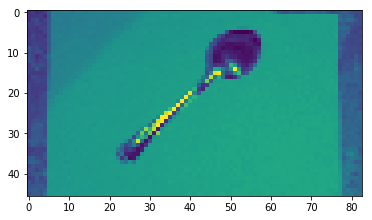

In [29]:

#reshape data
#retrieve first row, first 3818 columns and turn into a numpy array
img_data=np.array(df_retr_spoon.iloc[26,:3818], dtype=float) #make sure to specify data type as float when converting to an np array
#reshape data
img_data=img_data.reshape(46,83)

#having trouble to plot the image
#img_data.shape #check shape

plt.imshow(img_data)
plt.show()

**Summary**

- Retrieve images
- Standardize image orientation and size
- Save image to a DataFrame and apply label for later retieval